In [1]:
import torch
import pandas as pd
import numpy as np
from models.resnetv2 import ResNet50, ResNet101
from torchvision import datasets, transforms
from PIL import Image
import torch.utils.data as data
from melanoma.melanoma_loader import Melanoma_loader
import matplotlib.pyplot as plt
import os

def iterate_class(dataset, find_melanoma=1):
    for idx in range(len(dataset)):
        if dataset[idx][1] == find_melanoma:
            yield dataset[idx][0].view(1, 3, 256, 256), dataset.lookup_path(idx)

/home/maciej/Documents/Studia/Zima 2022/XAI/Project/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
WEIGHTS_PATH = 'model_melanoma'
if not os.path.exists(WEIGHTS_PATH):
    !wget -O $WEIGHTS_PATH 'https://www.dropbox.com/s/5gfs44hf282l22r/ckpt_epoch_18.pth?dl=0'

In [3]:
model = ResNet50(out_features = 2, freeze = True, in_channels = 3)
checkpoint1 = torch.load(WEIGHTS_PATH, map_location='cpu')
model.load_state_dict(checkpoint1['model'], strict=False)
model.eval()

ResNet50(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [4]:
dataset = Melanoma_loader(root = "melanoma/data/train/train", ann_path = "melanoma/data/test_set.csv",
                          transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256, 256)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))

In [5]:
generator = iterate_class(dataset)
test_tensor, path = next(generator)

In [6]:
from zennit.composites import (EpsilonPlusFlat, 
                                EpsilonGammaBox, 
                                EpsilonPlus, 
                                EpsilonAlpha2Beta1,
                                EpsilonAlpha2Beta1Flat,
                                DeconvNet,
                                GuidedBackprop,
                                ExcitationBackprop)
from zennit.torchvision import ResNetCanonizer
from zennit.attribution import Gradient

WIDTH = 256
HEIGHT = 256
ROOT = "melanoma/data/train/train/"

def stacked_img(img_path, extra_img):
    img = Image.open(ROOT + img_path + ".jpg")

    new_im = Image.new('RGB', (2 * WIDTH, HEIGHT))
    new_im.paste(img, (0, 0))
    new_im.paste(extra_img, (WIDTH, 0))
    return new_im

def show_sample(img_path):
    img = Image.open(ROOT + img_path + ".jpg")
    return img

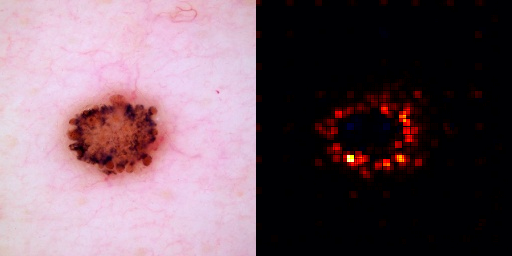

In [7]:
# use the ResNet-specific canonizer
canonizer = ResNetCanonizer()

for composite in [
                    EpsilonPlusFlat,
                    ]:
    # create a composite, specifying the canonizers
    composite = composite(canonizers=[canonizer])

    target = torch.Tensor([[1, 0]])
    # https://github.com/chr5tphr/zennit/blob/master/share/example/feed_forward.py#L149

    # create the attributor, specifying model and composite
    with Gradient(model=model, composite=composite) as attributor:
        # compute the model output and attribution
        output, attribution = attributor(test_tensor, target)
        
    from zennit.image import imgify
    # sum over the channels
    relevance = attribution.sum(1)

    # create an image of the visualize attribution
    img = imgify(relevance, symmetric=True, cmap='coldnhot')
    new_img = stacked_img(path, img)
    # show the image
    display(new_img)

In [8]:
# './melanoma/data/train/train/ISIC_0000004.jpg'
path

'ISIC_0030653'

In [9]:
while path != 'ISIC_0000004':
    test_tensor, path = next(generator)

for composite in [
                    EpsilonPlusFlat,
                    ]:
    # create a composite, specifying the canonizers
    composite = composite(canonizers=[canonizer])

    target = torch.Tensor([[1, 0]])
    # https://github.com/chr5tphr/zennit/blob/master/share/example/feed_forward.py#L149

    # create the attributor, specifying model and composite
    with Gradient(model=model, composite=composite) as attributor:
        # compute the model output and attribution
        output, attribution = attributor(test_tensor, target)
        
    from zennit.image import imgify
    # sum over the channels
    relevance = attribution.sum(1)

    # create an image of the visualize attribution
    img = imgify(relevance, symmetric=True, cmap='coldnhot')
    new_img = stacked_img(path, img)
    # show the image
    display(new_img)

StopIteration: 